# Tracking the objects in 3D using Kitti dataset

download the kitti dataset and calibration files by uncommenting below lines

In [28]:
#!python -m wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
#!python -m wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
#!python -m wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
#%pip install pillow==9.5.0

# a) Object Detection

Before tracking the objects we need to detect it.

In [2]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kitti_utils import *

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

In [6]:
file_path = r'2011_10_03_drive_0047_sync/2011_10_03/2011_10_03_drive_0047_sync'

# getting camera RGB data
left_img = sorted(glob(os.path.join(file_path, 'image_02/data/*.png')))
right_img = sorted(glob(os.path.join(file_path, 'image_03/data/*.png')))

#getting lidar data
bin_path = sorted(glob(os.path.join(file_path,'velodyne_points/data/*.bin')))

#getting GPS/IMU data
oxts_path = sorted(glob(os.path.join(file_path,r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_img)}")
print(f"Number of right images: {len(right_img)}")
print(f"Number of Lidar point clouds: {len(bin_path)}")
print(f"Number of GPS/IMU frames: {len(oxts_path)}")

Number of left images: 837
Number of right images: 837
Number of Lidar point clouds: 837
Number of GPS/IMU frames: 837


Get the Camera calibration data and transformation matrix

In [7]:
with open('2011_10_03_calib/2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib_cam = f.readlines()

# get projection matrices (Rectified left camera --> Left camera (u,v,z))
rect2_cam2 = np.array([float(x) for x in calib_cam[25].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices (Left camera --> rectified left camera)
R_rect2 = np.array([float(x) for x in calib_cam[24].strip().split(' ')[1:]]).reshape((3,3))

# convert to homogenous coordinates
R_rect2 = np.insert(R_rect2,3, values=[0,0,0], axis =0)
R_rect2 = np.insert(R_rect2,3, values=[0,0,0,1], axis =1)

# get transformation from camera 0 to camera 1
R_c0_c2 = np.array([float(x) for x in calib_cam[21].strip().split(' ')[1:]]).reshape((3,3))
T_c0_c2 = np.array([float(x) for x in calib_cam[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 transformation in homgenous coordinates
T_rect2 = np.insert(np.hstack((R_c0_c2,T_c0_c2)), 3, values = [0,0,0,1], axis=0)

Similarly get the Lidar and IMU calibration data and their transformations to camera

In [8]:
T_lid = get_rigid_transformation(r'2011_10_03_calib/2011_10_03/calib_velo_to_cam.txt')
T_imu = get_rigid_transformation(r'2011_10_03_calib/2011_10_03/calib_imu_to_velo.txt')

# transform from Lidar to left color camera and camera to lidar
T_lid_cam2 = rect2_cam2 @ R_rect2 @ T_rect2 @ T_lid
T_cam2_lid = np.linalg.inv(np.insert(T_lid_cam2, 3, values=[0,0,0,1], axis = 0))

# transform from imu to camera and camera to imu
T_imu_cam2 = T_lid_cam2 @ T_imu
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2,3 , values=[0,0,0,1], axis = 0))

Getting Yolo object detection pipeline

In [9]:
#!git clone https://github.com/ultralytics/yolov5
#%pip install -r yolov5/requirements.txt

# get the model
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\toukh/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-3-31 Python-3.11.0 torch-2.3.0+cpu CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 55.8MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [10]:
# set model confidence and IOU thresholds
model.conf = 0.25 # confidence threshold (0-1), default: 0.25
model.iou = 0.25 # NMS IoU threshold (0-1), default: 0.45

Dectection Pipeline
1) Detect Objects on Image
2) Project Lidar to (u,v,z)
3) Associate Detected object centers with (u,v,z) points
4) Transform (u,v,z) object centers to IMU (x,y,z) coordinates
5) Convert IMU to LLA


Finds closest LiDAR points to bounding box centers and adds (u,v,z) coordinates to them.

**Key Operations:**
1. Calculates box centers
2. Finds nearest LiDAR point (L2 norm)
3. Optionally draws depth text on image

In [11]:
def get_uvz_centers(img, lid_uvz, bboxes, draw=True):
    """
    Inputs:
    img: Image array
    lid_uvz: Tuple of LiDAR (u,v,z) projections
    bboxes: Array of [x1,y1,x2,y2] boxes    
    draw: Whether to annotate depths on image (default: True)

    Outputs:
    Enhanced bboxes array with added [u,v,z] columns for closest LiDAR points.
    """
    u, v, z = lid_uvz

    # get new output
    bboxes_output = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_output[:, : bboxes.shape[1]] = bboxes

    # iterate through all detected bouding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest Lidar points to center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[obj_x_center, obj_y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis = 0))

        # get lidar location im image/camera space
        lid_depth = z[min_loc]
        uvz_location = np.array([u[min_loc], v[min_loc], lid_depth])
        
        # add lidar projections  (u,v,z) to bboxes_out
        bboxes_output[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int), np.round(obj_x_center).astype(int))
            cv2.putText(img, '{0:.2f} m'.format(lid_depth),
                        object_center, # top_left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255,0,0), 2, cv2.LINE_AA)
        
    return bboxes_output

Processes an image to detect objects and match them with LiDAR data.

In [ ]:
def get_detection_coordinates(img,bin,draw_boxes=True, draw_depth =True):
    """
    Inputs:
    - img: Input image (numpy array)
    - bin: LiDAR point cloud data (binary format)
    - draw_boxes: Whether to visualize bounding boxes (default: True)
    - draw_depth: Whether to annotate depth on image (default: True)

    Outputs:
    - bboxes: Enhanced detection array with:
      - Original bounding box coordinates (x1,y1,x2,y2)
      - Probability and class
      - Closest LiDAR (u,v,z) coordinates appended
    - lid_uvz: Projected LiDAR points in image space
    """
    #1. compute detections in left image
    detections = model(img)

    #if draw_boxes:
    #    detections.show()

    #get bouding boxes locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu()

    # get lidar points and trsnaform them to image/camera space
    lid_uvz = project_velobin2uvz(bin,T_lid_cam2,img,remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(img,lid_uvz,bboxes,draw= draw_depth)

    return bboxes,lid_uvz

In [10]:
#%pip install pymap3d

Converts IMU-centric (x,y,z) coordinates to geodetic (lat,lon,alt) coordinates.



**Transformation Process:**
1. Converts local coordinates to spherical (Range-Azimuth-Elevation):
2. Uses `pymap3d.aer2geodetic` to convert RAE to geodetic coordinates


In [ ]:
import pymap3d as pm

def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    """
    Inputs:
    - x, y, z: Local IMU frame coordinates (meters)
    - lat0, lon0, alt0: Reference origin point (degrees, degrees, meters)
    - heading0: IMU heading angle at origin (radians)

    Output:
    - lla: Array of geodetic coordinates [latitude, longitude, altitude] in (degrees, degrees, meters)
    """
    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y,x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90

    # convert to geodetic
    lla = pm.aer2geodetic(az,el,rng, lat0, lon0, alt0)

    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

## Testing


Processes camera images with LiDAR data to get object positions in geographic coordinates.

In [15]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_img[index]), cv2.COLOR_BGR2RGB)
bin_paths = bin_path[index]
oxts_frame = get_oxts(oxts_path[index])


# get detection and object centers in uvz
bboxes, lid_uvz = get_detection_coordinates(left_image,bin_paths)

# get transformed coordiantes of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [16]:
lid_img = draw_velo_on_image(lid_uvz, np.zeros_like(left_image))

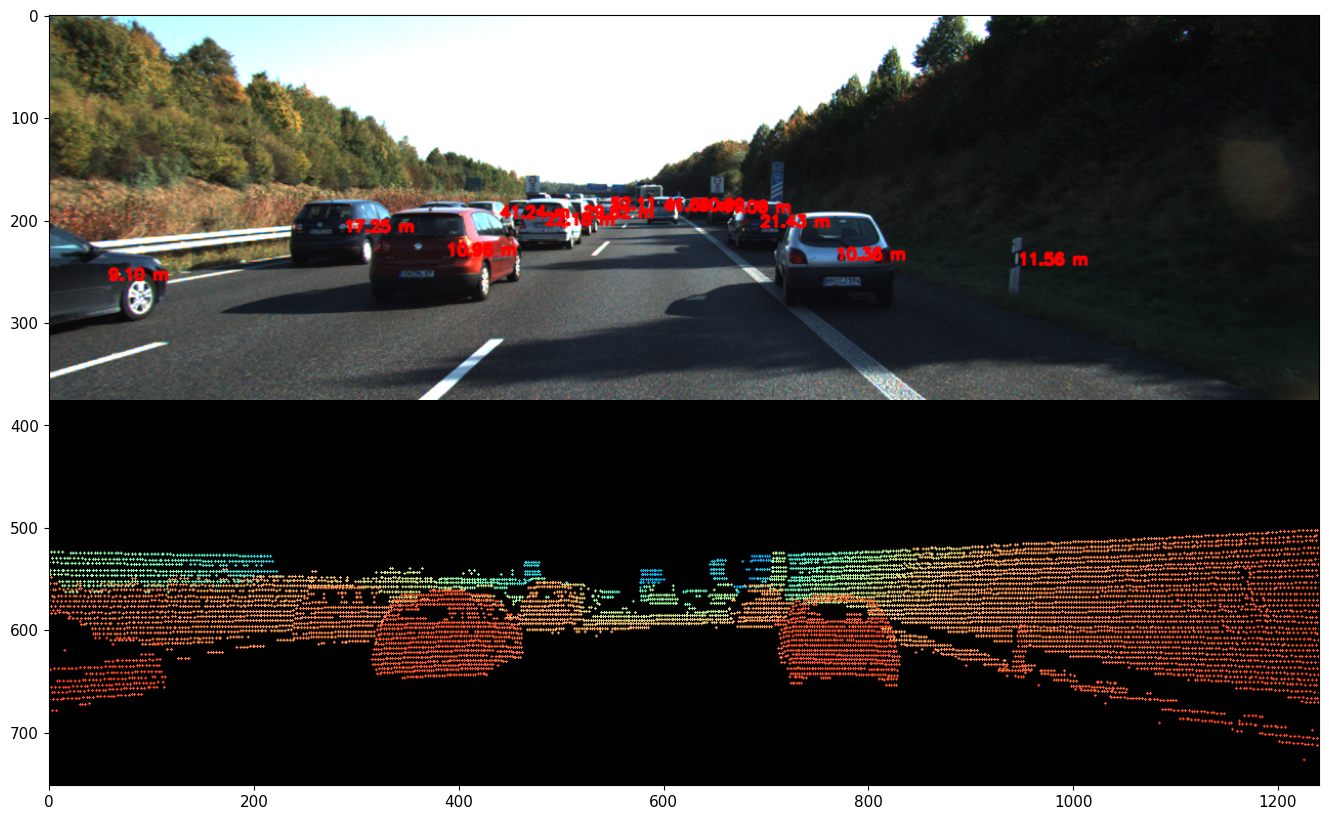

In [17]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

# stack image with Lidar point cloud
stacked = np.vstack((left_image, lid_img))

# display stacked image
plt.imshow(stacked)

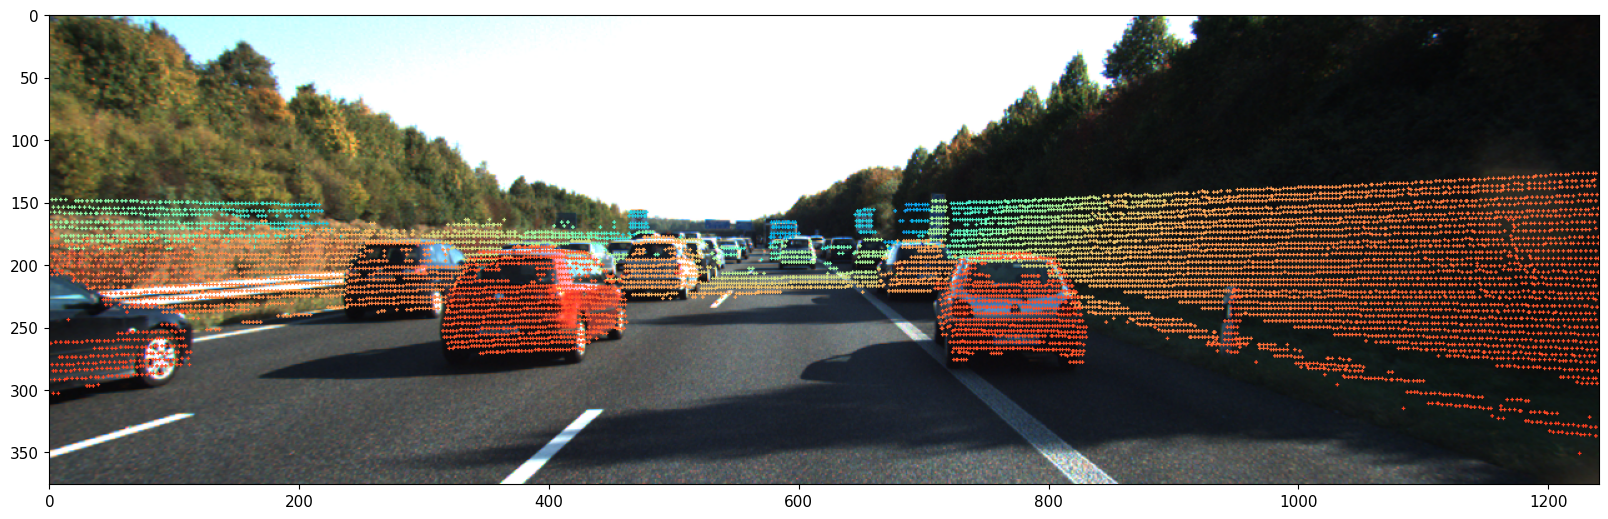

In [18]:
left_cam_img = cv2.cvtColor(cv2.imread(left_img[index]), cv2.COLOR_BGR2RGB)
lid_img_ = draw_velo_on_image(lid_uvz, left_cam_img)

plt.imshow(lid_img_)

# Bird's-Eye View Visualization

In [ ]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordinates for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10


def draw_scenario(canvas, imu_xyz, sf=12):
    """ 
    Inputs:
    - canvas: Background image (3-channel numpy array)
    - imu_xyz: Array of object coordinates in IMU frame (x,y,z)
    - sf: Scale factor (default=12) for distance visualization
    """
    #draw ego vehicle
    cv2.rectangle(canvas, (ego_x1,ego_y1), (ego_x2,ego_y2), (0,255,0), -1)

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        
        #get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255,0,0),-1)
    
    return canvas
        

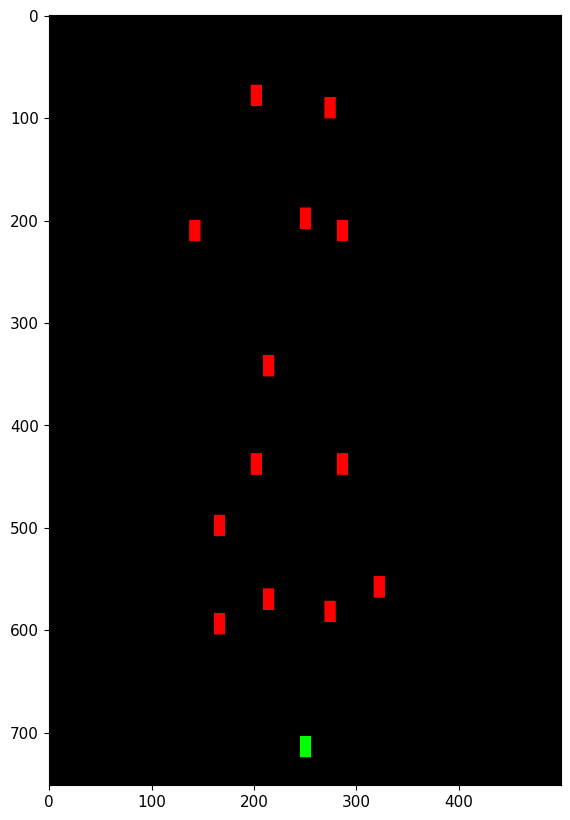

In [22]:
canvas = np.zeros((canvas_height,canvas_width, 3), dtype=np.uint8)
draw_scenario(canvas, imu_xyz, sf = 12)
plt.imshow(canvas)

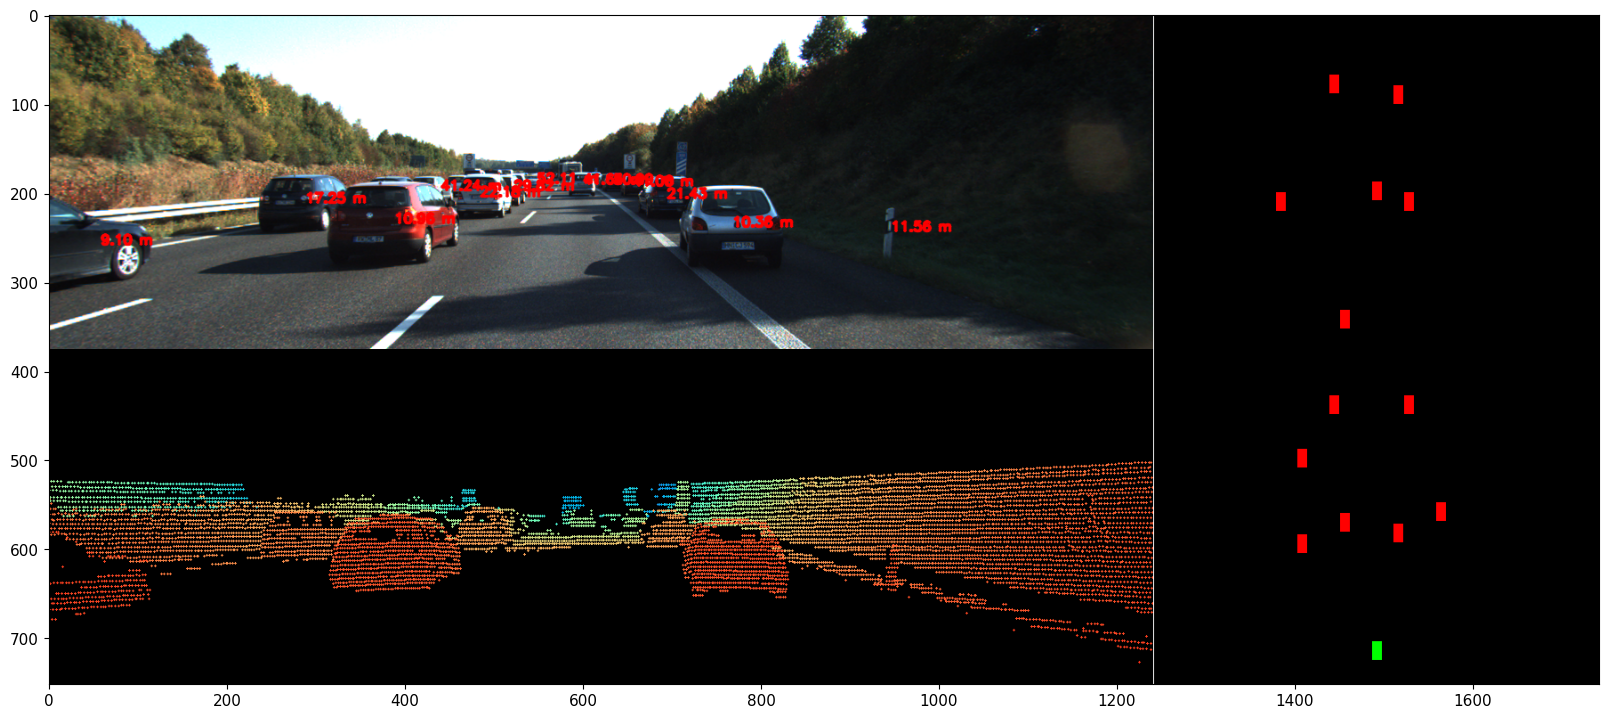

In [23]:
frame = np.hstack((stacked,255*np.ones((canvas_height,1,3),dtype=np.uint8),canvas))

plt.imshow(frame)

## Result

Converts timestamp strings to total seconds for frame rate calculation.

In [24]:
def timestamps2seconds(timestamp_path):
    """ Input:
    - timestamp_path: Path to text file containing timestamps (format: YYYY-MM-DD HH:MM:SS.SSS)
    """
    # Read timestamps and extract the time part (after space)
    timestamps = pd.read_csv(timestamp_path, header=None).iloc[:, 0].str.split(' ').str[1]
    
    # Split into hours, minutes, seconds and convert to numeric
    hms = timestamps.str.split(':', expand=True).astype(float)
    
    # Calculate total seconds
    total_seconds = hms[0] * 3600 + hms[1] * 60 + hms[2]
    
    return total_seconds.values  # Return as numpy array

cam2_total_seconds = timestamps2seconds(os.path.join(file_path, 'image_02/timestamps.txt'))
cam2_fps = 1 / np.median(np.diff(cam2_total_seconds))
cam2_fps

9.650971459539951

Processes camera images with LiDAR data to create an annotated output video.

In [25]:
result_video = []

for index in range(len(left_img)):
    """ 
    Inputs:
    - left_img: List of left camera image paths
    - bin_path: List of LiDAR binary data paths
    - oxts_path: List of OXTS sensor data paths
    """
    left_image = cv2.cvtColor(cv2.imread(left_img[index]),cv2.COLOR_BGR2RGB)
    bin = bin_path[index]
    oxts_frame = get_oxts(oxts_path[index])

    # get detections and object centers in uvz
    bboxes, lid_uvz = get_detection_coordinates(left_image,bin)

    # get transformed coordinates
    uvz = bboxes[:, -3:]

    # lid_xyz = transform(uvz, T_cam2_lid) we can also get lidar coordinates
    imu_xyz = transform_uvz(uvz, T_cam2_imu)

    # draw lidar blank image
    lid_img = draw_velo_on_image(lid_uvz, np.zeros_like(left_image))

    # stack frames
    stacked = np.vstack((left_image, lid_img))

    # draw top down scenario on canvas
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype= np.uint8)
    draw_scenario(canvas, imu_xyz, sf = 12)

    # palce everything in a single frame
    frame = np.hstack((stacked, 255*np.ones((canvas_height, 1, 3), dtype=np.uint8), canvas))

    # add to the video
    result_video.append(frame)

# get width and height for video frames
h, w, _ = frame.shape




In [26]:
out = cv2.VideoWriter('lidar_frame_stack.avi',cv2.VideoWriter_fourcc(*'DIVX'), cam2_fps,(w,h))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

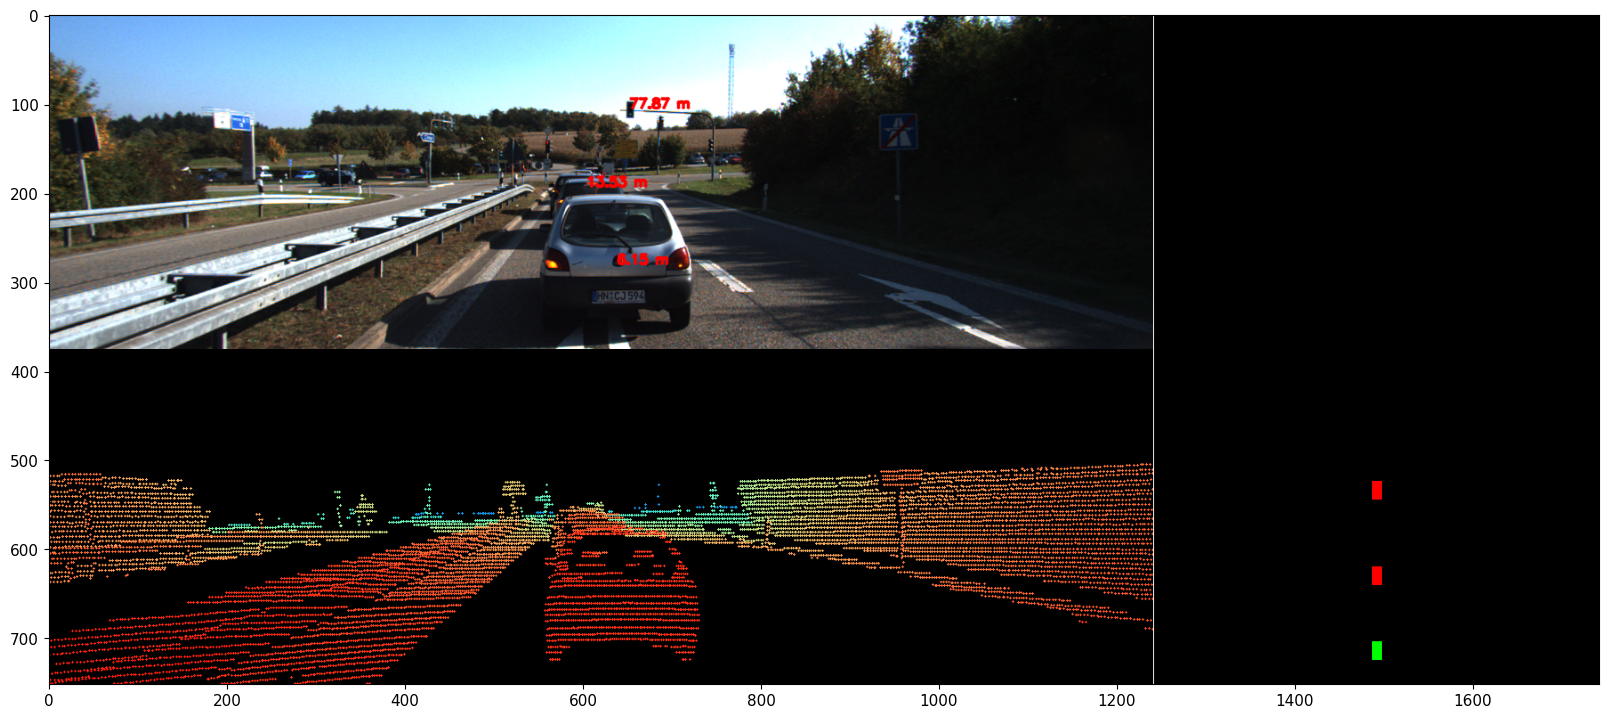

In [27]:
plt.imshow(frame)